In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Parkinson’s Disease Classification Using Smartwatch Sensor & Clinical Data (PADS Dataset)

## 🧾 Introduction
This project explores the use of wearable sensor data and clinical metadata to classify individuals with Parkinson's Disease (PD) versus non-Parkinsonian subjects. The aim is to build an **interpretable, high-performance binary classifier** using motion signals and non-motor symptoms.

---

## Dataset Overview

- **Source**: [PADS – Parkinson’s Disease Smartwatch Dataset v1.0.0](https://physionet.org/content/parkinsons-disease-smartwatch/1.0.0/)
- **Participants**: 469 subjects
- **Labels**: Binary — PD vs. non-PD (includes healthy & other movement disorders)
- **Sensors**: Accelerometer & gyroscope (mostly wrist-mounted)
- **Clinical Data**:
  - Questionnaire responses (30+ non-motor symptoms)
  - Demographic metadata (age, sex, diagnosis info)
- **Tasks Used**: TouchNose, Relaxed, PointFinger

---

##  Data Exploration

- Visualized and summarized demographics & labels
- Mapped patient IDs across motion/questionnaire/metadata files
- Previewed sample sensor signals from wrist tasks
- Verified PD label distribution (291 PD, 178 non-PD)

---

##  Data Preprocessing

- Loaded motion signals & questionnaire responses
- Merged all data by patient ID
- Normalized motion time-series data
- Extracted sensor data per task
- Filtered for consistent format and quality

---

##  Feature Engineering

- Extracted motion features:
  - **Time-domain**: RMS, entropy
  - **Frequency-domain**: dominant frequency
- Performed task-wise feature extraction on:
  - `TouchNose`, `Relaxed`, `PointFinger`
- Merged features with:
  - Age, gender, diagnosis delay, handedness
  - Questionnaire binary responses (e.g., taste loss, urinary urgency)

---

##  Model Building

- Split data into train/test sets (stratified)
- Models trained:
  - Random Forest (baseline, pruned, tuned)
  - XGBoost (for SHAP explainability)
- Feature selection:
  - Used SHAP to reduce from 97 → Top 30
- Hyperparameter tuning:
  - GridSearchCV on Random Forest for final AUC

---

##  Model Evaluation

- **Best Model:** Random Forest (Top 30 features, tuned)
- **AUC:** 0.9150
- Other metrics:
  - Accuracy: 86%
  - Precision/Recall/F1
  - MCC: 0.685
  - Brier Score: 0.114
- Feature importance: SHAP, Fisher Discriminant Ratio

---

##  Results & Visualizations

- SHAP summary: Top clinical & motion features
- PCA & t-SNE: Visual class separability
- Confusion matrix: Model balance on PD vs. non-PD

---

## Conclusion

- **What did the model learn?**
  - Non-motor symptoms like `taste_smell_loss`, `sleep_talk_move`
  - Dynamic task signals (e.g., `TouchNose` entropy)
- **Most informative features:**
  - `diagnosis_delay`, `urinary_urgency`, `gyro_z_entropy`
- **Limitations:**
  - Small sample size, only 3 motion tasks used
- **Future Work:**
  - Expand to all 11 tasks (e.g., HoldWeight, CrossArms)
  - Real-time smartwatch integration
  - Add UPDRS for severity scoring

---


# Data Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


### Loading Dataset

In [5]:
import os

# Explore subdirectories inside the main dataset folder
base_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/'

for dirpath, dirnames, filenames in os.walk(base_path):
    print(f"Directory: {dirpath}")
    for f in filenames[:5]:  # show first 5 files per folder
        print("  -", f)


Directory: /kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/
  - SHA256SUMS.txt
  - LICENSE.txt
Directory: /kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/scripts
  - run_preprocessing_parallel.py
  - create_csv_file_list.py
  - create_csv_stratified_subset.py
  - hc_078_questionnaire.jpg
  - pd_060_signal_processed.jpg
Directory: /kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/scripts/utils
  - dict_handling.py
  - l1_trend_filter.py
  - constants.py
  - data_handling.py
  - __init__.py
Directory: /kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/preprocessed
  - file_list.csv
Directory: /kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/preprocessed/movement
  - 158_ml.bin
  - 339_ml.bin
  - 326_ml.bin
  - 351_ml.bin
  - 124_ml.bin
Directory: /kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/preprocessed/questionnaire
  - 158_ml.bin
  - 339_ml.bin
  - 326_ml.bin
  - 351_ml.bin
  - 124_ml.bin
Directory: /kaggle/input/pads-parkinsons-disease-smar

## Estimated structure:

PADS Dataset
│
├── movement/
│   ├── timeseries/
│   │   ├── 207_PointFinger_RightWrist.txt     ← actual motion data
│   │   ├── 338_CrossArms_LeftWrist.txt        ← actual motion data
│   └── observation_207.json                   ← info about the movement task
│
├── patients/
│   ├── patient_207.json                       ← the person’s diagnosis (PD or healthy)
│
├── questionnaire/
│   ├── questionnaire_response_207.json        ← their yes/no symptom answers
│
├── preprocessed/ (not needed)
│
├── scripts/ (ignore for now)


In [19]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load time-series motion data
# -------------------------------
# Corrected: use comma as separator
# Load correctly as comma-separated
df = pd.read_csv(motion_file, header=None)

# Set proper column names manually (based on documentation)
df.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Show result
print(df.shape)
df.head()


(1024, 7)


,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,0.000000,-0.340824,-0.119788,0.278623,0.531370,-0.079897,-0.479162
1,0.010022,-0.342259,-0.129319,0.310301,0.495787,-0.149096,-0.466446
2,0.019874,-0.334529,-0.086738,0.327441,0.393580,-0.170886,-0.416526
3,0.029878,-0.345207,-0.059547,0.307490,0.214568,-0.192199,-0.351711
4,0.039965,-0.387149,-0.058125,0.266768,-0.028707,-0.196314,-0.331478


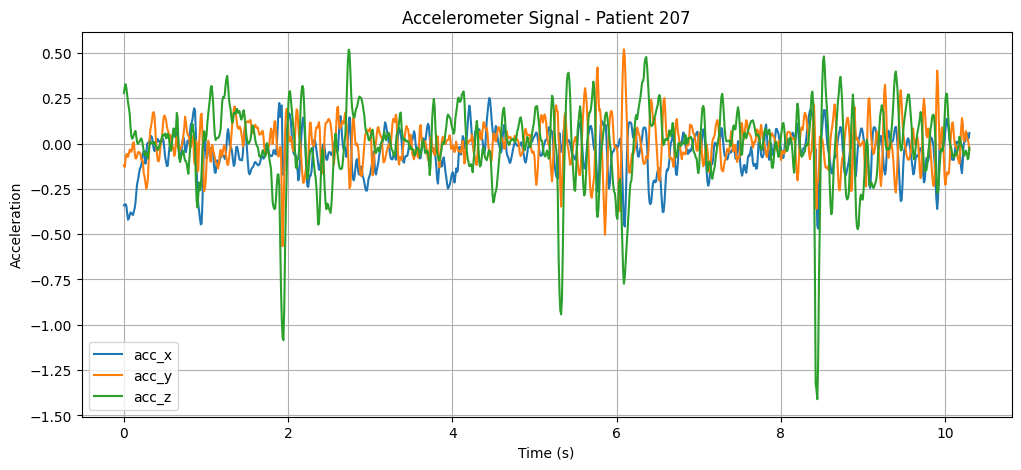

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['acc_x'], label='acc_x')
plt.plot(df['timestamp'], df['acc_y'], label='acc_y')
plt.plot(df['timestamp'], df['acc_z'], label='acc_z')
plt.title('Accelerometer Signal - Patient X')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# 2. Load diagnosis label from patient JSON

patient_id = '032'
json_path = f'/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/patients/patient_{patient_id}.json'

with open(json_path, 'r') as f:
    patient_info = json.load(f)

# Print diagnosis info
print("Diagnosis:", patient_info.get("diagnosis", "Not found"))


Diagnosis: Not found


In [33]:
import os
import glob

data_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/movement/timeseries/'

# List all files
all_files = sorted(glob.glob(data_path + '*.txt'))
print(f"Found {len(all_files)} time-series files")

# Show first few file names
for file in all_files[:50]:
    print(os.path.basename(file))


Found 10318 time-series files
001_CrossArms_LeftWrist.txt
001_CrossArms_RightWrist.txt
001_DrinkGlas_LeftWrist.txt
001_DrinkGlas_RightWrist.txt
001_Entrainment_LeftWrist.txt
001_Entrainment_RightWrist.txt
001_HoldWeight_LeftWrist.txt
001_HoldWeight_RightWrist.txt
001_LiftHold_LeftWrist.txt
001_LiftHold_RightWrist.txt
001_PointFinger_LeftWrist.txt
001_PointFinger_RightWrist.txt
001_RelaxedTask_LeftWrist.txt
001_RelaxedTask_RightWrist.txt
001_Relaxed_LeftWrist.txt
001_Relaxed_RightWrist.txt
001_StretchHold_LeftWrist.txt
001_StretchHold_RightWrist.txt
001_TouchIndex_LeftWrist.txt
001_TouchIndex_RightWrist.txt
001_TouchNose_LeftWrist.txt
001_TouchNose_RightWrist.txt
002_CrossArms_LeftWrist.txt
002_CrossArms_RightWrist.txt
002_DrinkGlas_LeftWrist.txt
002_DrinkGlas_RightWrist.txt
002_Entrainment_LeftWrist.txt
002_Entrainment_RightWrist.txt
002_HoldWeight_LeftWrist.txt
002_HoldWeight_RightWrist.txt
002_LiftHold_LeftWrist.txt
002_LiftHold_RightWrist.txt
002_PointFinger_LeftWrist.txt
002_PointF

In [40]:
import json

with open('/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/patients/patient_005.json', 'r') as f:
    patient_data = json.load(f)

# Pretty print for dictiopnary
import pprint
pprint.pprint(patient_data)


{'age': 75,
 'age_at_diagnosis': 65,
 'appearance_in_first_grade_kinship': None,
 'appearance_in_kinship': False,
 'condition': "Parkinson's",
 'disease_comment': 'IPS tremordominant type',
 'effect_of_alcohol_on_tremor': 'Unknown',
 'gender': 'male',
 'handedness': 'left',
 'height': 172,
 'id': '005',
 'resource_type': 'patient',
 'study_id': 'PADS',
 'weight': 86}


In [39]:
import json
import os
from glob import glob

patient_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/patients/'
patient_files = sorted(glob(patient_path + 'patient_*.json'))

# Store diagnoses
patient_labels = {}

for file in patient_files:
    with open(file, 'r') as f:
        patient_data = json.load(f)
        pid = file.split('_')[-1].split('.')[0]  # Extract '001' from filename
        diagnosis = patient_data.get('condition', 'Unknown')  # <-- fixed key
        patient_labels[pid] = diagnosis

# Show first 10
for pid, diag in list(patient_labels.items())[:10]:
    print(f"Patient {pid}: {diag}")


Patient 001: Healthy
Patient 002: Other Movement Disorders
Patient 003: Healthy
Patient 004: Parkinson's
Patient 005: Parkinson's
Patient 006: Parkinson's
Patient 007: Other Movement Disorders
Patient 008: Parkinson's
Patient 009: Parkinson's
Patient 010: Parkinson's


### We Pick One Healthy and One Parkinson Patient and  try to check the difference according to the sensors

In [47]:
columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Use comma as the correct separator
df_healthy = pd.read_csv(healthy_file, sep=',', header=None, names=columns)
df_pd = pd.read_csv(pd_file, sep=',', header=None, names=columns)

# Optional: check and convert to numeric just in case
df_healthy = df_healthy.apply(pd.to_numeric, errors='coerce')
df_pd = df_pd.apply(pd.to_numeric, errors='coerce')

# Preview
print(df_healthy.head())
print(df_pd.head())


   timestamp     acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z
0   0.000000 -0.003882 -0.013240 -0.010029  0.050900 -0.004418  0.051197
1   0.009898 -0.005322 -0.007130 -0.011563  0.044433  0.001885  0.050140
2   0.019967 -0.001839 -0.004931 -0.007296  0.033724  0.004906  0.039526
3   0.030009  0.000786  0.000098 -0.007113  0.010290  0.002479  0.025738
4   0.040144 -0.000383 -0.006639 -0.008066 -0.005712  0.001209  0.015123
   timestamp     acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z
0   0.000000 -0.013676  0.027143 -0.002059 -0.230716  0.069132 -0.060674
1   0.009850 -0.010785  0.023571 -0.010736 -0.229795  0.084044 -0.053234
2   0.019872 -0.010976  0.025820 -0.010735 -0.243850  0.101932 -0.057469
3   0.029813 -0.016101  0.000721 -0.011836 -0.258814  0.106081 -0.051087
4   0.040063 -0.016420  0.009565 -0.018966 -0.280296  0.119639 -0.058506


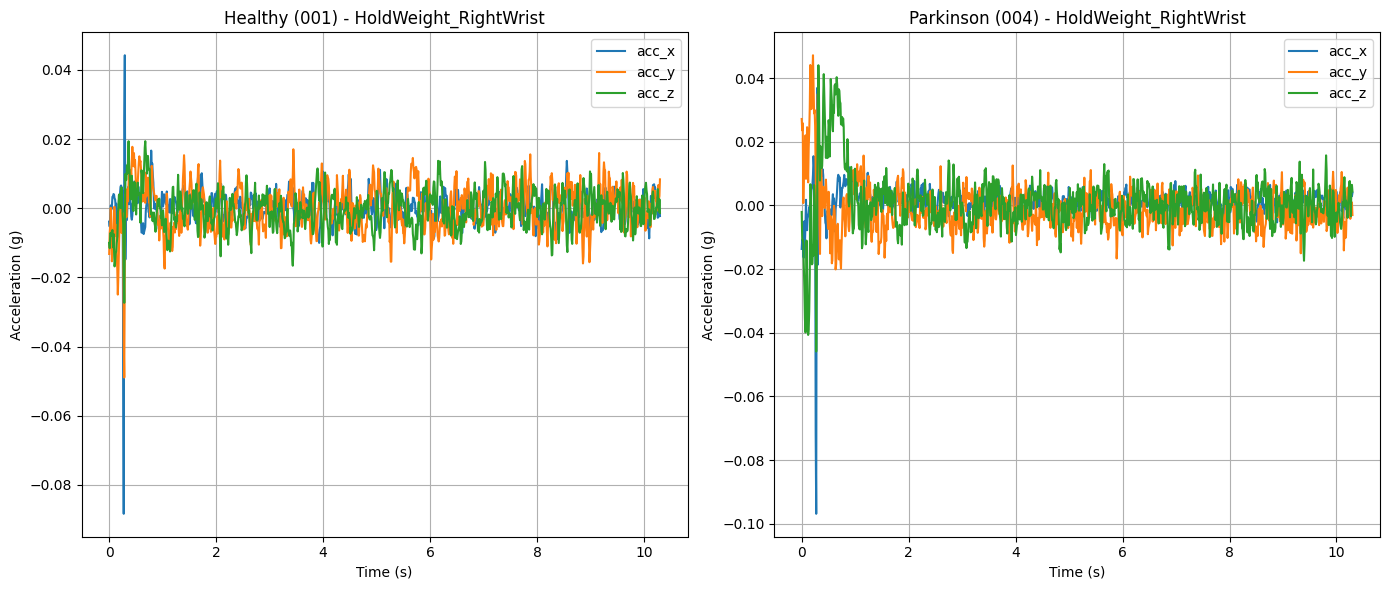

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Healthy plot
plt.subplot(1, 2, 1)
plt.plot(df_healthy['timestamp'], df_healthy['acc_x'], label='acc_x')
plt.plot(df_healthy['timestamp'], df_healthy['acc_y'], label='acc_y')
plt.plot(df_healthy['timestamp'], df_healthy['acc_z'], label='acc_z')
plt.title('Healthy (001) - HoldWeight_RightWrist')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

# Parkinson plot
plt.subplot(1, 2, 2)
plt.plot(df_pd['timestamp'], df_pd['acc_x'], label='acc_x')
plt.plot(df_pd['timestamp'], df_pd['acc_y'], label='acc_y')
plt.plot(df_pd['timestamp'], df_pd['acc_z'], label='acc_z')
plt.title('Parkinson (004) - HoldWeight_RightWrist')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [52]:
N = 1000  # number of rows to keep (tweak this)
df_healthy_subset = df_healthy.head(N)
df_pd_subset = df_pd.head(N)


In [53]:
import os
from glob import glob

base = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/movement/timeseries/'
files = glob(base + '001_*.txt')  # change patient ID if needed

# Print file lengths
for f in files:
    df = pd.read_csv(f, sep=',', header=None)
    print(f"{os.path.basename(f)} — {len(df)} rows")


001_LiftHold_LeftWrist.txt — 1024 rows
001_Relaxed_LeftWrist.txt — 2048 rows
001_Entrainment_RightWrist.txt — 2048 rows
001_CrossArms_RightWrist.txt — 1024 rows
001_HoldWeight_LeftWrist.txt — 1024 rows
001_LiftHold_RightWrist.txt — 1024 rows
001_TouchNose_LeftWrist.txt — 1024 rows
001_Entrainment_LeftWrist.txt — 2048 rows
001_DrinkGlas_RightWrist.txt — 1024 rows
001_PointFinger_RightWrist.txt — 1024 rows
001_HoldWeight_RightWrist.txt — 1024 rows
001_Relaxed_RightWrist.txt — 2048 rows
001_StretchHold_LeftWrist.txt — 1024 rows
001_TouchNose_RightWrist.txt — 1024 rows
001_StretchHold_RightWrist.txt — 1024 rows
001_TouchIndex_LeftWrist.txt — 1024 rows
001_TouchIndex_RightWrist.txt — 1024 rows
001_RelaxedTask_LeftWrist.txt — 2048 rows
001_DrinkGlas_LeftWrist.txt — 1024 rows
001_CrossArms_LeftWrist.txt — 1024 rows
001_RelaxedTask_RightWrist.txt — 2048 rows
001_PointFinger_LeftWrist.txt — 1024 rows


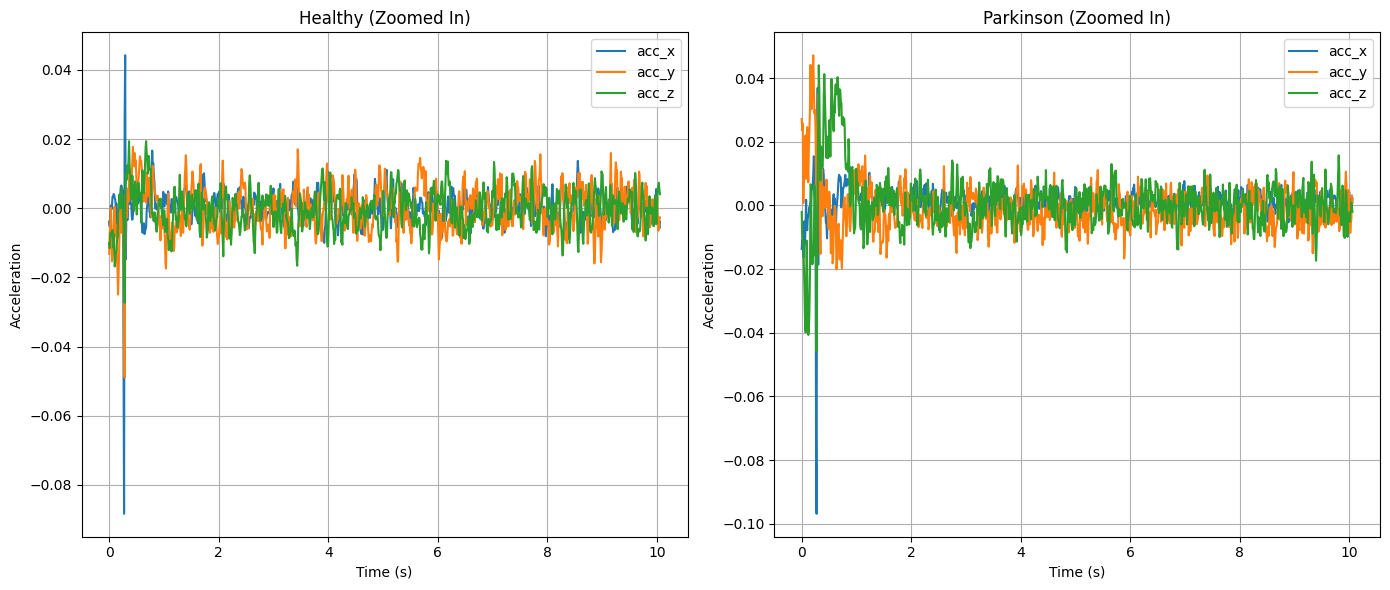

In [54]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df_healthy_subset['timestamp'], df_healthy_subset['acc_x'], label='acc_x')
plt.plot(df_healthy_subset['timestamp'], df_healthy_subset['acc_y'], label='acc_y')
plt.plot(df_healthy_subset['timestamp'], df_healthy_subset['acc_z'], label='acc_z')
plt.title('Healthy (Zoomed In)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_pd_subset['timestamp'], df_pd_subset['acc_x'], label='acc_x')
plt.plot(df_pd_subset['timestamp'], df_pd_subset['acc_y'], label='acc_y')
plt.plot(df_pd_subset['timestamp'], df_pd_subset['acc_z'], label='acc_z')
plt.title('Parkinson (Zoomed In)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [55]:
task = 'TouchNose_RightWrist.txt'
healthy_id = '001'
pd_id = '004'
base_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/movement/timeseries/'
columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

healthy_file = base_path + f'{healthy_id}_{task}'
pd_file = base_path + f'{pd_id}_{task}'

df_healthy = pd.read_csv(healthy_file, sep=',', header=None, names=columns)
df_pd = pd.read_csv(pd_file, sep=',', header=None, names=columns)

In [56]:
# Limit to first 2 seconds (e.g., 200–300 samples depending on sampling rate)
N = 300
df_healthy_zoom = df_healthy.head(N)
df_pd_zoom = df_pd.head(N)


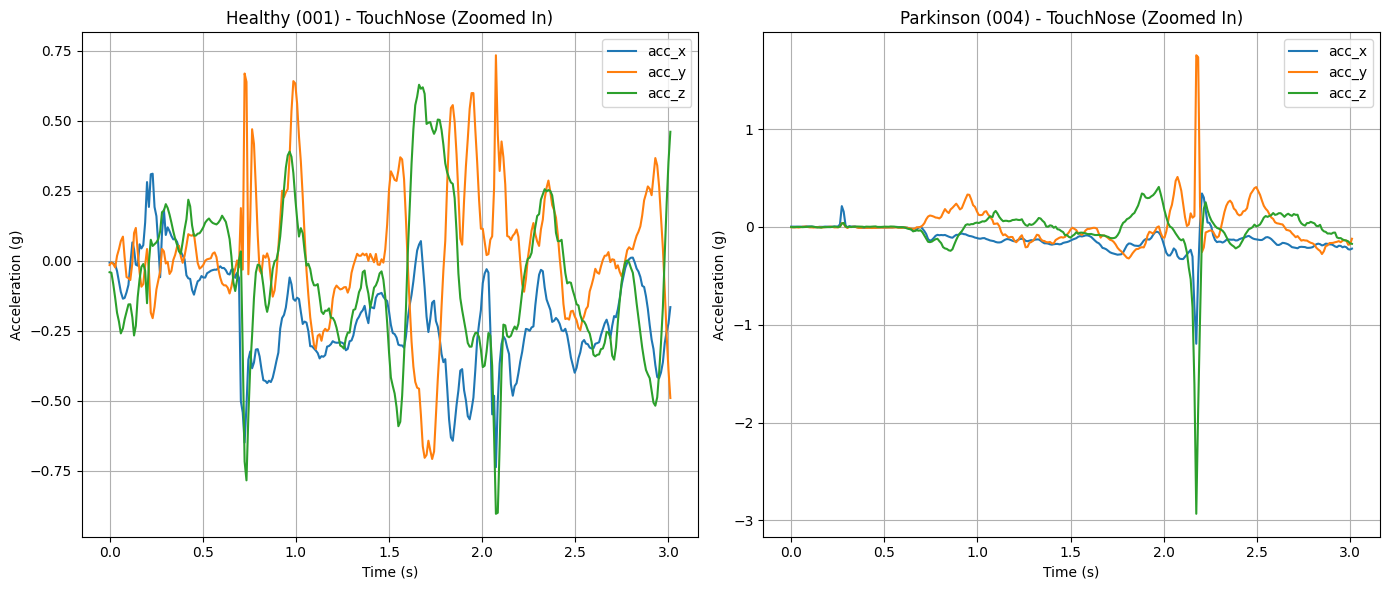

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df_healthy_zoom['timestamp'], df_healthy_zoom['acc_x'], label='acc_x')
plt.plot(df_healthy_zoom['timestamp'], df_healthy_zoom['acc_y'], label='acc_y')
plt.plot(df_healthy_zoom['timestamp'], df_healthy_zoom['acc_z'], label='acc_z')
plt.title('Healthy (001) - TouchNose (Zoomed In)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_pd_zoom['timestamp'], df_pd_zoom['acc_x'], label='acc_x')
plt.plot(df_pd_zoom['timestamp'], df_pd_zoom['acc_y'], label='acc_y')
plt.plot(df_pd_zoom['timestamp'], df_pd_zoom['acc_z'], label='acc_z')
plt.title('Parkinson (004) - TouchNose (Zoomed In)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Result
Healthy signal - smooth movement

Parkinson - randon spike more irregularity

Explore Patients by Diagnosis
Understand the distribution of:

Parkinson's

Healthy

Other Movement Disorders (called “Differential Diagnosis” in some datasets)

In [58]:
import json
import os
import pandas as pd
from glob import glob

patient_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/patients/'
patient_files = sorted(glob(patient_path + 'patient_*.json'))

patients = []

for file in patient_files:
    with open(file, 'r') as f:
        data = json.load(f)
        patients.append({
            'id': data.get('id'),
            'age': data.get('age'),
            'age_at_diagnosis': data.get('age_at_diagnosis'),
            'gender': data.get('gender'),
            'handedness': data.get('handedness'),
            'condition': data.get('condition'),
            'comment': data.get('disease_comment'),
        })

patients_df = pd.DataFrame(patients)
patients_df.head()


,id,age,age_at_diagnosis,gender,handedness,condition,comment
0,001,56,56,male,right,Healthy,-
1,002,81,69,male,right,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...
2,003,45,45,female,right,Healthy,-
3,004,67,63,female,right,Parkinson's,IPS akinetic-rigid type
4,005,75,65,male,left,Parkinson's,IPS tremordominant type


normalize and count

In [59]:
# Normalize values
patients_df['condition'] = patients_df['condition'].str.strip().str.lower()

# Value counts
print(patients_df['condition'].value_counts())


condition
parkinson's                 276
healthy                      79
other movement disorders     60
essential tremor             28
atypical parkinsonism        15
multiple sclerosis           11
Name: count, dtype: int64


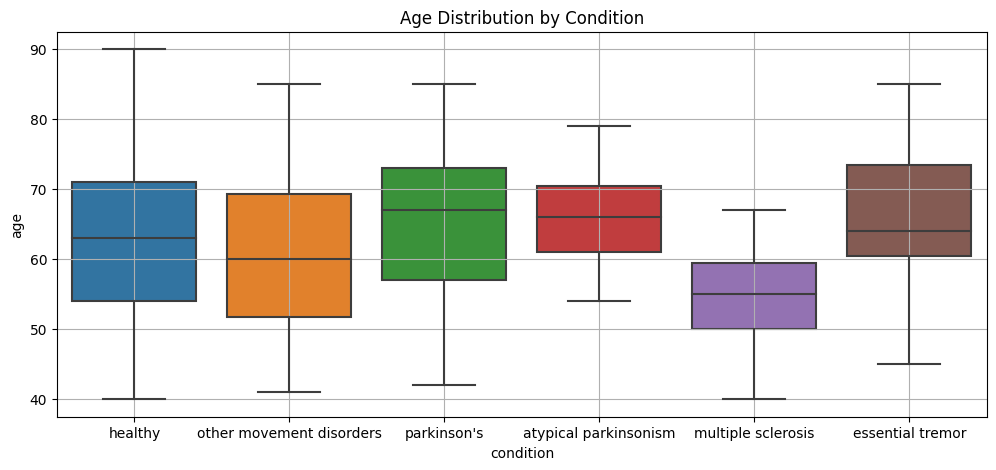

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.boxplot(data=patients_df, x='condition', y='age')
plt.title('Age Distribution by Condition')
plt.grid(True)
plt.show()


In [62]:
question_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/questionnaire/'
q_files = sorted(glob(question_path + 'questionnaire_response_*.json'))

questionnaires = []

for file in q_files:
    with open(file, 'r') as f:
        data = json.load(f)
        subject_id = file.split('_')[-1].split('.')[0]
        answers = {'id': subject_id}
        
        # Flatten answers: yes/no → 1/0
        for k, v in data.get('questionnaire', {}).items():
            if isinstance(v, str):
                v = v.lower().strip()
                if v in ['yes', 'true', '1']:
                    answers[k] = 1
                elif v in ['no', 'false', '0']:
                    answers[k] = 0
                else:
                    answers[k] = None
        questionnaires.append(answers)

q_df = pd.DataFrame(questionnaires)
q_df.head()

,id
0,001
1,002
2,003
3,004
4,005


# Data Preprocessing
We'll classify:


**Parkinson’s (1) vs Not Parkinson’s (0)using data you understand: yes/no questionnaire answers (no medical decoding needed).Prepare X and y**


In [30]:
import json
import pandas as pd
from glob import glob

# Load patient metadata
patient_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/patients/'
patient_files = sorted(glob(patient_path + 'patient_*.json'))

patients = []

for file in patient_files:
    with open(file, 'r') as f:
        data = json.load(f)
        patients.append({
            'id': data.get('id'),
            'age': data.get('age'),
            'age_at_diagnosis': data.get('age_at_diagnosis'),
            'height': data.get('height'),
            'weight': data.get('weight'),
            'gender': data.get('gender'),
            'handedness': data.get('handedness'),
            'appearance_in_kinship': data.get('appearance_in_kinship'),
            'alcohol_effect': data.get('effect_of_alcohol_on_tremor'),
            'condition': data.get('condition').strip().lower() if data.get('condition') else None
        })

patients_df = pd.DataFrame(patients)

patients_df['label'] = patients_df['condition'].apply(lambda x: 1 if 'parkinson' in x else 0)
patients_df['gender'] = patients_df['gender'].map({'male': 0, 'female': 1})
patients_df['handedness'] = patients_df['handedness'].map({'right': 0, 'left': 1})
patients_df['appearance_in_kinship'] = patients_df['appearance_in_kinship'].astype(float)
patients_df.head()
print("Shape", patients_df.shape)

Shape (469, 11)


In [34]:
import json
import pandas as pd
from glob import glob

question_path = '/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/questionnaire/'
q_files = sorted(glob(question_path + 'questionnaire_response_*.json'))

questionnaires = []

for file in q_files:
    with open(file, 'r') as f:
        data = json.load(f)

    patient_id = data['subject_id'].zfill(3)
    entry = {'id': patient_id}

    # Flatten each question text → answer (1/0)
    for item in data.get('item', []):
        question = item['text'].strip()
        answer = item['answer']
        entry[question] = int(bool(answer))

    questionnaires.append(entry)

q_df = pd.DataFrame(questionnaires)
print("Questionare shape:", q_df.shape)
q_df.head()

Questionare shape: (469, 31)


,id,Dribbling of saliva during the daytime,Loss or change in your ability to taste or smell,Difficulty swallowing food or drink or problems with choking,Vomiting or feelings of sickness (nausea),Constipation (less than 3 bowel movements a week) or having to strain to pass a stool (faeces),Bowel (fecal) incontinence,Feeling that your bowel emptying is incomplete after having been to the toilet,A sense of urgency to pass urine makes you rush to the toilet,Getting up regularly at night to pass urine,...,Falling,"Finding it difficult to stay awake during activities such as working, driving or eating",Difficulty getting to sleep at night or staying asleep at night,"Intense, vivid dreams or frightening dreams",Talking or moving about in your sleep as if you are acting out a dream,"Unpleasant sensations in your legs at night or while resting, and a feeling that you need to move",Swelling of your legs,Excessive sweating,Double vision,Believing things are happening to you that other people say are not true
0,001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,002,1,1,0,0,1,0,0,0,1,...,1,1,1,0,1,0,1,0,1,0
2,003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,004,0,1,0,1,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,0
4,005,1,1,1,0,0,0,0,1,0,...,0,1,1,1,1,1,1,0,0,0


In [36]:
rename_map = {
    "Dribbling of saliva during the daytime": "saliva_dribble",
    "Loss or change in your ability to taste or smell": "taste_smell_loss",
    "Difficulty swallowing food or drink or problems with choking": "swallow_difficulty",
    "Vomiting or feelings of sickness (nausea)": "nausea",
    "Constipation (less than 3 bowel movements a week) or having to strain to pass a stool (faeces)": "constipation",
    "Bowel (fecal) incontinence": "fecal_incontinence",
    "Feeling that your bowel emptying is incomplete after having been to the toilet": "bowel_incomplete",
    "A sense of urgency to pass urine makes you rush to the toilet": "urinary_urgency",
    "Getting up regularly at night to pass urine": "nocturia",
    "Falling": "falling",
    "Finding it difficult to stay awake during activities such as working, driving or eating": "daytime_sleepiness",
    "Difficulty getting to sleep at night or staying asleep at night": "insomnia",
    "Intense, vivid dreams or frightening dreams": "vivid_dreams",
    "Talking or moving about in your sleep as if you are acting out a dream": "sleep_talk_move",
    "Unpleasant sensations in your legs at night or while resting, and a feeling that you need to move": "restless_legs",
    "Swelling of your legs": "leg_swelling",
    "Excessive sweating": "sweating",
    "Double vision": "double_vision",
    "Believing things are happening to you that other people say are not true": "delusions"
}
q_df = q_df.rename(columns=rename_map)
q_df.head()

,id,saliva_dribble,taste_smell_loss,swallow_difficulty,nausea,constipation,fecal_incontinence,bowel_incomplete,urinary_urgency,nocturia,...,falling,daytime_sleepiness,insomnia,vivid_dreams,sleep_talk_move,restless_legs,leg_swelling,sweating,double_vision,delusions
0,001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,002,1,1,0,0,1,0,0,0,1,...,1,1,1,0,1,0,1,0,1,0
2,003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,004,0,1,0,1,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,0
4,005,1,1,1,0,0,0,0,1,0,...,0,1,1,1,1,1,1,0,0,0


In [37]:
patients_df['id'] = patients_df['id'].astype(str).str.zfill(3)
q_df['id'] = q_df['id'].astype(str).str.zfill(3)

merged_df = pd.merge(patients_df, q_df, on='id', how='inner')

print("Final shape:", merged_df.shape)
merged_df.head()


Final shape: (469, 41)


,id,age,age_at_diagnosis,height,weight,gender,handedness,appearance_in_kinship,alcohol_effect,condition,...,falling,daytime_sleepiness,insomnia,vivid_dreams,sleep_talk_move,restless_legs,leg_swelling,sweating,double_vision,delusions
0,001,56,56,173,78,0,0,1.0,Unknown,healthy,...,0,0,0,0,0,0,0,0,0,0
1,002,81,69,193,104,0,0,0.0,No effect,other movement disorders,...,1,1,1,0,1,0,1,0,1,0
2,003,45,45,170,78,1,0,0.0,Unknown,healthy,...,0,0,0,0,0,0,0,0,0,0
3,004,67,63,161,90,1,0,0.0,No effect,parkinson's,...,1,1,1,0,0,1,1,1,0,0
4,005,75,65,172,86,0,1,0.0,Unknown,parkinson's,...,0,1,1,1,1,1,1,0,0,0


# Feature Engineering

In [41]:
# Add BMI
merged_df['bmi'] = merged_df['weight'] / (merged_df['height'] / 100) ** 2

# Time between diagnosis and now
merged_df['diagnosis_delay'] = merged_df['age'] - merged_df['age_at_diagnosis']

# Clean 'alcohol_effect' into numeric (optional)
merged_df['alcohol_effect'] = merged_df['alcohol_effect'].map({
    'no effect': 0,
    'unknown': 0.5,
    'improvement': 1,
    'worsening': -1
}).fillna(0.5)


In [43]:
merged_df.columns

Index(['id', 'age', 'age_at_diagnosis', 'height', 'weight', 'gender',
       'handedness', 'appearance_in_kinship', 'alcohol_effect', 'condition',
       'label', 'saliva_dribble', 'taste_smell_loss', 'swallow_difficulty',
       'nausea', 'constipation', 'fecal_incontinence', 'bowel_incomplete',
       'urinary_urgency', 'nocturia',
       'Unexplained pains (not due to known conditions such as arthritis)',
       'Unexplained change in weight (not due to change in diet)',
       'Problems remembering things that have happened recently or forgetting to do things',
       'Loss of interest in what is happening around you or doing things',
       'Seeing or hearing things that you know or are told are not there',
       'Difficulty concentrating or staying focussed',
       'Feeling sad, low or blue', 'Feeling anxious, frightened or panicky',
       'Feeling less interested in sex or more interested in sex',
       'Finding it difficult to have sex when you try',
       'Feeling light h

In [44]:
rename_map = {
    'Unexplained pains (not due to known conditions such as arthritis)': 'unexplained_pains',
    'Unexplained change in weight (not due to change in diet)': 'weight_change',
    'Problems remembering things that have happened recently or forgetting to do things': 'memory_issues',
    'Loss of interest in what is happening around you or doing things': 'anhedonia',
    'Seeing or hearing things that you know or are told are not there': 'hallucinations',
    'Difficulty concentrating or staying focussed': 'concentration_issues',
    'Feeling sad, low or blue': 'depression',
    'Feeling anxious, frightened or panicky': 'anxiety',
    'Feeling less interested in sex or more interested in sex': 'sex_interest_change',
    'Finding it difficult to have sex when you try': 'sexual_dysfunction',
    'Feeling light headed, dizzy or weak standing from sitting or lying': 'orthostatic_dizziness'
}
merged_df = merged_df.rename(columns=rename_map)
merged_df.columns

Index(['id', 'age', 'age_at_diagnosis', 'height', 'weight', 'gender',
       'handedness', 'appearance_in_kinship', 'alcohol_effect', 'condition',
       'label', 'saliva_dribble', 'taste_smell_loss', 'swallow_difficulty',
       'nausea', 'constipation', 'fecal_incontinence', 'bowel_incomplete',
       'urinary_urgency', 'nocturia', 'unexplained_pains', 'weight_change',
       'memory_issues', 'anhedonia', 'hallucinations', 'concentration_issues',
       'depression', 'anxiety', 'sex_interest_change', 'sexual_dysfunction',
       'orthostatic_dizziness', 'falling', 'daytime_sleepiness', 'insomnia',
       'vivid_dreams', 'sleep_talk_move', 'restless_legs', 'leg_swelling',
       'sweating', 'double_vision', 'delusions', 'bmi', 'diagnosis_delay'],
      dtype='object')

In [47]:
import os
import pandas as pd
import numpy as np
from glob import glob
from scipy.stats import entropy
from scipy.signal import welch

# -----------------------------
# Helper Functions
# -----------------------------
def rms(x):
    return np.sqrt(np.mean(np.square(x)))

def signal_entropy(x):
    hist, _ = np.histogram(x, bins=30, density=True)
    return entropy(hist + 1e-6)

def dominant_freq(x, fs=100):
    f, Pxx = welch(x, fs=fs)
    return f[np.argmax(Pxx)] if len(f) > 0 else 0

# -----------------------------
# Config
# -----------------------------
tasks = ["TouchNose_RightWrist", "PointFinger_RightWrist", "Relaxed_RightWrist"]
data_path = "/kaggle/input/pads-parkinsons-disease-smartwatch-v1-0-0/movement/timeseries/"
columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Get all patient IDs (or from your merged_df if available)
patient_ids = sorted(list(set(f.split("/")[-1].split("_")[0] for f in glob(data_path + "*.txt"))))

features = []
# Feature Extraction Loop

for pid in patient_ids:
    feature_row = {"id": pid}
    
    for task in tasks:
        file_path = os.path.join(data_path, f"{pid}_{task}.txt")
        if not os.path.exists(file_path):
            continue
        
        try:
            df = pd.read_csv(file_path, sep=",", header=None, names=columns)
            df = df.apply(pd.to_numeric, errors='coerce').dropna()

            for axis in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
                sig = df[axis]
                prefix = f"{task}_{axis}"
                feature_row[f"{prefix}_rms"] = rms(sig)
                feature_row[f"{prefix}_entropy"] = signal_entropy(sig)
                feature_row[f"{prefix}_dom_freq"] = dominant_freq(sig)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    features.append(feature_row)


motion_features_df = pd.DataFrame(features)
print("Shape:", motion_features_df.shape)
motion_features_df.head()


Shape: (469, 55)


,id,TouchNose_RightWrist_acc_x_rms,TouchNose_RightWrist_acc_x_entropy,TouchNose_RightWrist_acc_x_dom_freq,TouchNose_RightWrist_acc_y_rms,TouchNose_RightWrist_acc_y_entropy,TouchNose_RightWrist_acc_y_dom_freq,TouchNose_RightWrist_acc_z_rms,TouchNose_RightWrist_acc_z_entropy,TouchNose_RightWrist_acc_z_dom_freq,...,Relaxed_RightWrist_acc_z_dom_freq,Relaxed_RightWrist_gyro_x_rms,Relaxed_RightWrist_gyro_x_entropy,Relaxed_RightWrist_gyro_x_dom_freq,Relaxed_RightWrist_gyro_y_rms,Relaxed_RightWrist_gyro_y_entropy,Relaxed_RightWrist_gyro_y_dom_freq,Relaxed_RightWrist_gyro_z_rms,Relaxed_RightWrist_gyro_z_entropy,Relaxed_RightWrist_gyro_z_dom_freq
0,001,0.265874,2.653495,0.781250,0.249991,2.564113,0.781250,0.270251,2.830151,1.562500,...,7.031250,0.011871,2.070930,4.687500,0.020571,0.220006,1.562500,0.013211,0.464883,1.562500
1,002,0.188329,1.285489,1.171875,0.237472,1.093334,1.171875,0.291629,1.446207,1.562500,...,5.468750,0.278966,2.765552,5.468750,0.094446,2.594961,5.468750,0.038548,2.643865,5.468750
2,003,0.399926,2.743637,2.734375,0.803645,3.009734,1.171875,0.544838,2.553510,2.734375,...,14.453125,0.003515,1.666279,10.156250,0.010730,0.798032,5.468750,0.003309,1.950062,0.390625
3,004,0.235974,1.983640,3.125000,0.310855,1.892319,0.781250,0.376352,1.902993,1.562500,...,5.859375,0.013968,2.625465,1.171875,0.014110,0.962378,0.390625,0.007996,2.163227,1.171875
4,005,0.145924,2.801995,0.781250,0.363734,2.775767,0.781250,0.218605,2.649229,1.171875,...,4.687500,0.999470,3.171692,4.687500,0.412977,2.913960,4.687500,0.342216,3.022417,4.687500


In [48]:
# Ensure both IDs are strings with leading zeros
motion_features_df['id'] = motion_features_df['id'].astype(str).str.zfill(3)
merged_df['id'] = merged_df['id'].astype(str).str.zfill(3)

final_df = pd.merge(merged_df, motion_features_df, on='id', how='inner')
print("Final dataset shape:", final_df.shape)
final_df.head()


Final dataset shape: (469, 97)


,id,age,age_at_diagnosis,height,weight,gender,handedness,appearance_in_kinship,alcohol_effect,condition,...,Relaxed_RightWrist_acc_z_dom_freq,Relaxed_RightWrist_gyro_x_rms,Relaxed_RightWrist_gyro_x_entropy,Relaxed_RightWrist_gyro_x_dom_freq,Relaxed_RightWrist_gyro_y_rms,Relaxed_RightWrist_gyro_y_entropy,Relaxed_RightWrist_gyro_y_dom_freq,Relaxed_RightWrist_gyro_z_rms,Relaxed_RightWrist_gyro_z_entropy,Relaxed_RightWrist_gyro_z_dom_freq
0,001,56,56,173,78,0,0,1.0,0.5,healthy,...,7.031250,0.011871,2.070930,4.687500,0.020571,0.220006,1.562500,0.013211,0.464883,1.562500
1,002,81,69,193,104,0,0,0.0,0.5,other movement disorders,...,5.468750,0.278966,2.765552,5.468750,0.094446,2.594961,5.468750,0.038548,2.643865,5.468750
2,003,45,45,170,78,1,0,0.0,0.5,healthy,...,14.453125,0.003515,1.666279,10.156250,0.010730,0.798032,5.468750,0.003309,1.950062,0.390625
3,004,67,63,161,90,1,0,0.0,0.5,parkinson's,...,5.859375,0.013968,2.625465,1.171875,0.014110,0.962378,0.390625,0.007996,2.163227,1.171875
4,005,75,65,172,86,0,1,0.0,0.5,parkinson's,...,4.687500,0.999470,3.171692,4.687500,0.412977,2.913960,4.687500,0.342216,3.022417,4.687500


# Model Building

Random Forest AUC: 0.9042
XGBoost AUC: 0.8884


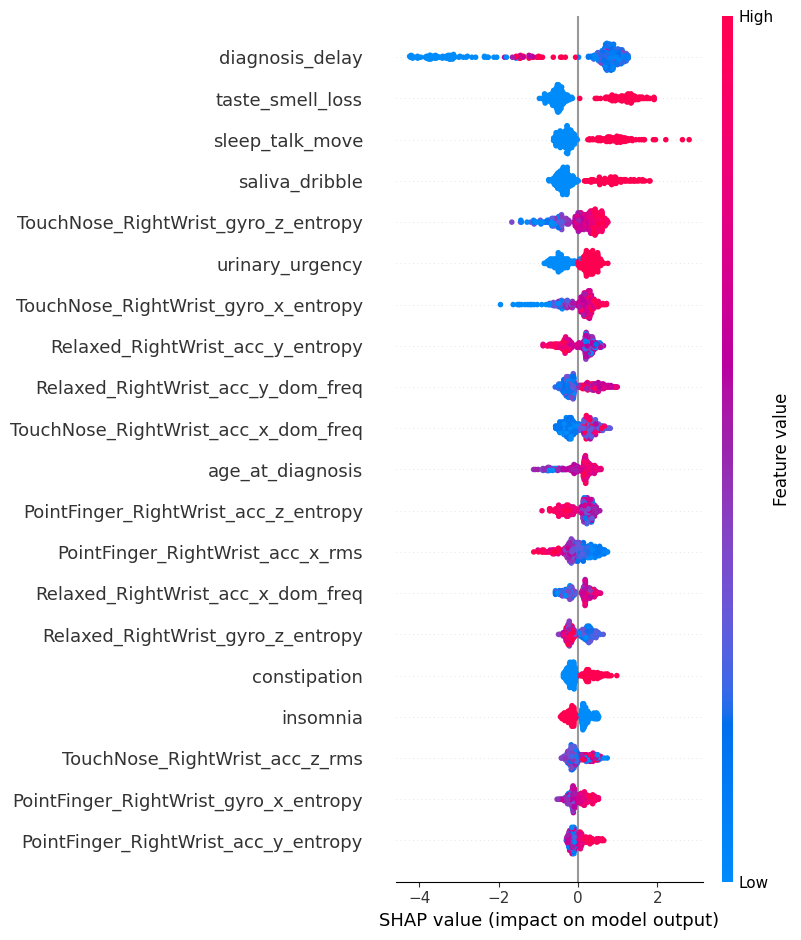

In [49]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt


# Drop non-feature columns
X = final_df.drop(columns=['id', 'condition', 'label'], errors='ignore')
y = final_df['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_preds = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"Random Forest AUC: {rf_auc:.4f}")

# 4. XGBoost

xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_preds)
print(f"XGBoost AUC: {xgb_auc:.4f}")


# 5. SHAP for XGBoost
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

# Plot summary of top features
shap.summary_plot(shap_values, X_train, max_display=20)


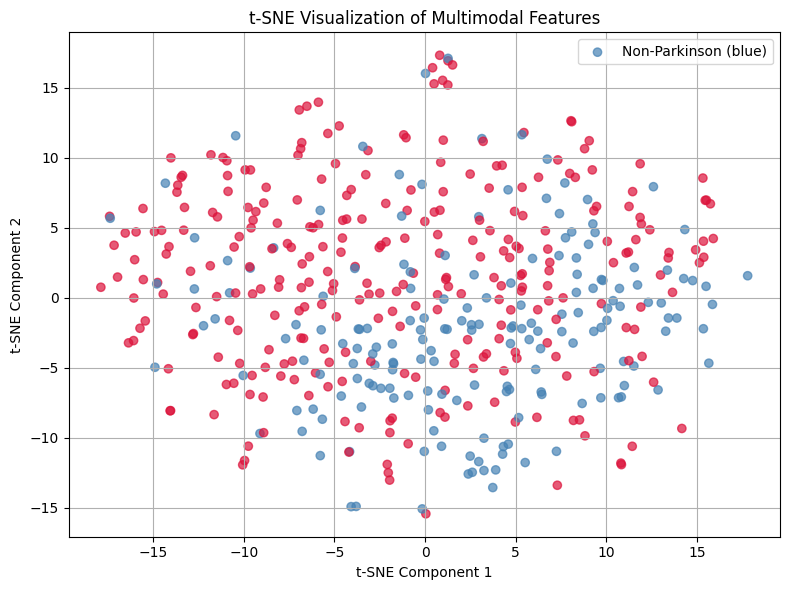

In [50]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X_tsne = final_df.drop(columns=['id', 'condition', 'label'], errors='ignore')
y_tsne = final_df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tsne)


tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne_2d = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
colors = ['steelblue' if label == 0 else 'crimson' for label in y_tsne]
plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=colors, alpha=0.7)
plt.title('t-SNE Visualization of Multimodal Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.legend(['Non-Parkinson (blue)', 'Parkinson (red)'])
plt.tight_layout()
plt.show()


In [51]:
# 1. Get mean absolute SHAP values from the SHAP explanation
import numpy as np
import pandas as pd

# Compute mean SHAP value per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_summary_df = pd.DataFrame({
    'feature': X_train.columns,
    'mean_shap': shap_importance
}).sort_values(by='mean_shap', ascending=False)

# 2. Choose top N features
top_n = 30  # or try 20
top_features = shap_summary_df['feature'].iloc[:top_n].tolist()
print(f"Selected top {top_n} features:")
print(top_features)

# 3. Recreate reduced dataset
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# 4. Retrain XGBoost with reduced features
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_reduced = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_reduced.fit(X_train_reduced, y_train)

preds_reduced = xgb_reduced.predict_proba(X_test_reduced)[:, 1]
auc_reduced = roc_auc_score(y_test, preds_reduced)
print(f"Reduced XGBoost AUC: {auc_reduced:.4f}")


Selected top 30 features:
['diagnosis_delay', 'taste_smell_loss', 'sleep_talk_move', 'saliva_dribble', 'TouchNose_RightWrist_gyro_z_entropy', 'urinary_urgency', 'TouchNose_RightWrist_gyro_x_entropy', 'Relaxed_RightWrist_acc_y_entropy', 'Relaxed_RightWrist_acc_y_dom_freq', 'TouchNose_RightWrist_acc_x_dom_freq', 'age_at_diagnosis', 'PointFinger_RightWrist_acc_z_entropy', 'PointFinger_RightWrist_acc_x_rms', 'Relaxed_RightWrist_acc_x_dom_freq', 'Relaxed_RightWrist_gyro_z_entropy', 'constipation', 'insomnia', 'TouchNose_RightWrist_acc_z_rms', 'PointFinger_RightWrist_gyro_x_entropy', 'PointFinger_RightWrist_acc_y_entropy', 'TouchNose_RightWrist_gyro_z_dom_freq', 'Relaxed_RightWrist_gyro_z_dom_freq', 'PointFinger_RightWrist_gyro_z_entropy', 'PointFinger_RightWrist_gyro_z_dom_freq', 'Relaxed_RightWrist_acc_y_rms', 'TouchNose_RightWrist_acc_y_entropy', 'nocturia', 'Relaxed_RightWrist_acc_z_dom_freq', 'weight', 'Relaxed_RightWrist_gyro_x_entropy']
Reduced XGBoost AUC: 0.8817


Use SHAP from XGBoost for feature selection,
Train final model with Random Forest for best performance.

Metric	Before (Full Model)	After (Top 30 Features)
AUC	0.8884	0.8817

nearly 70% fewer features.

**Questionnaire --  ~10 --	taste_smell_loss, insomnia, nocturia <br>
Engineered Demographics --	2 --	diagnosis_delay, age_at_diagnosisSignal <br>
Features (TouchNose, Relaxed, PointFinger) --	~18  --	TouchNose_RightWrist_gyro_z_entropy, etc.**




In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 1. Use the same top 30 features from XGBoost SHAP
X_train_rf_reduced = X_train[top_features]
X_test_rf_reduced = X_test[top_features]

# 2. Train Random Forest
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_rf_reduced, y_train)

# 3. Predict and Evaluate
rf_preds_reduced = rf_reduced.predict_proba(X_test_rf_reduced)[:, 1]
rf_auc_reduced = roc_auc_score(y_test, rf_preds_reduced)

print(f"Reduced Random Forest AUC: {rf_auc_reduced:.4f}")


Reduced Random Forest AUC: 0.9142


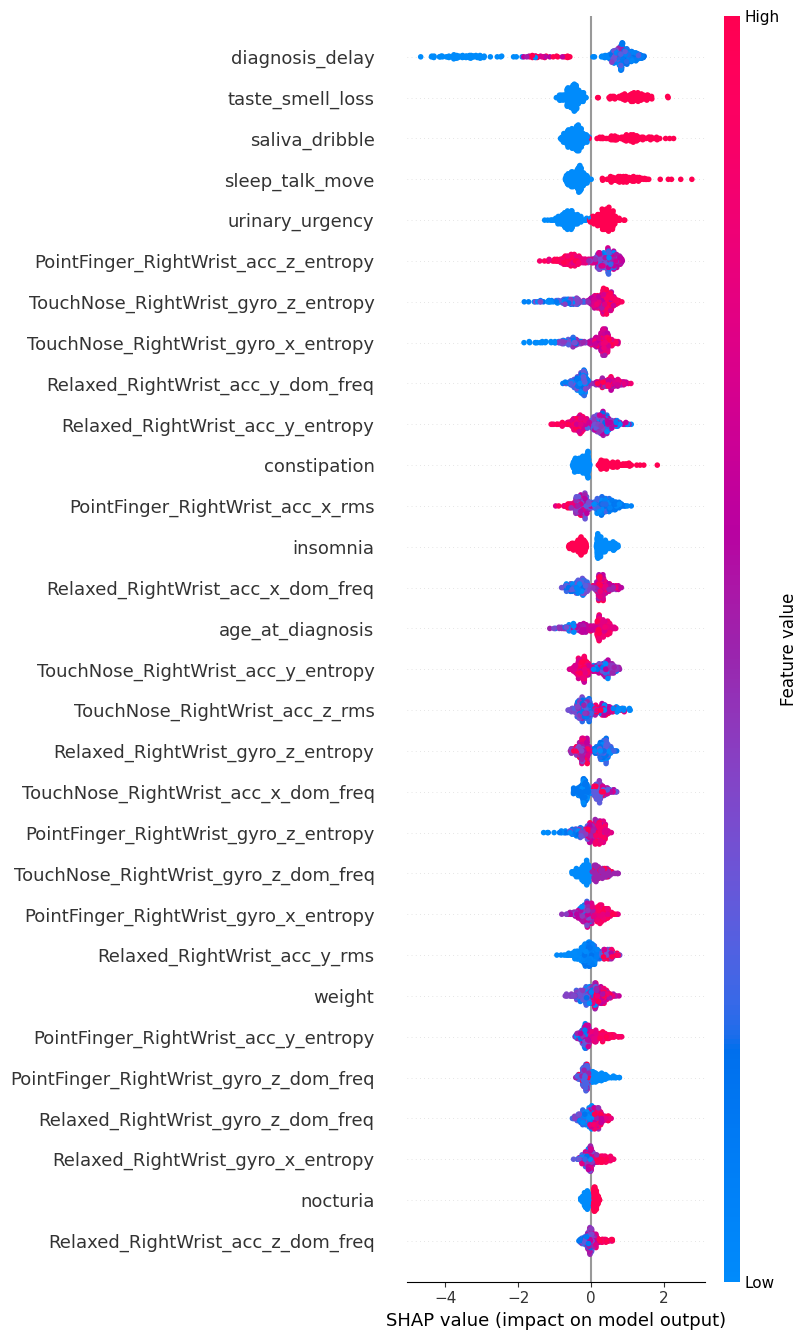

In [53]:
import shap
import matplotlib.pyplot as plt

# Re-explain model using only top features
explainer_reduced = shap.Explainer(xgb_reduced)
shap_values_reduced = explainer_reduced(X_train_reduced)

# SHAP Summary Plot for Top 30
shap.summary_plot(shap_values_reduced, X_train_reduced, max_display=30)


label
1    291
0    178
Name: count, dtype: int64


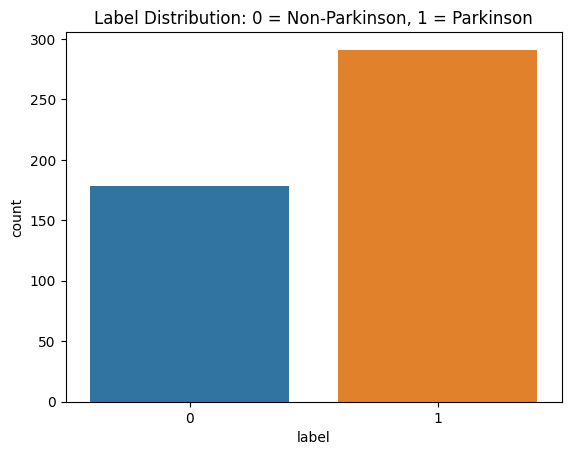

In [54]:
label_counts = final_df['label'].value_counts()
print(label_counts)

# Visual check
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=final_df)
plt.title('Label Distribution: 0 = Non-Parkinson, 1 = Parkinson')
plt.show()


# Model Evaluation

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

y_pred_rf = best_rf.predict(X_test_rf_reduced)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Matthews Corr Coeff:", matthews_corrcoef(y_test, y_pred_rf))


Confusion Matrix:
 [[24  7]
 [ 6 57]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79        31
           1       0.89      0.90      0.90        63

    accuracy                           0.86        94
   macro avg       0.85      0.84      0.84        94
weighted avg       0.86      0.86      0.86        94

Matthews Corr Coeff: 0.6847653684518729


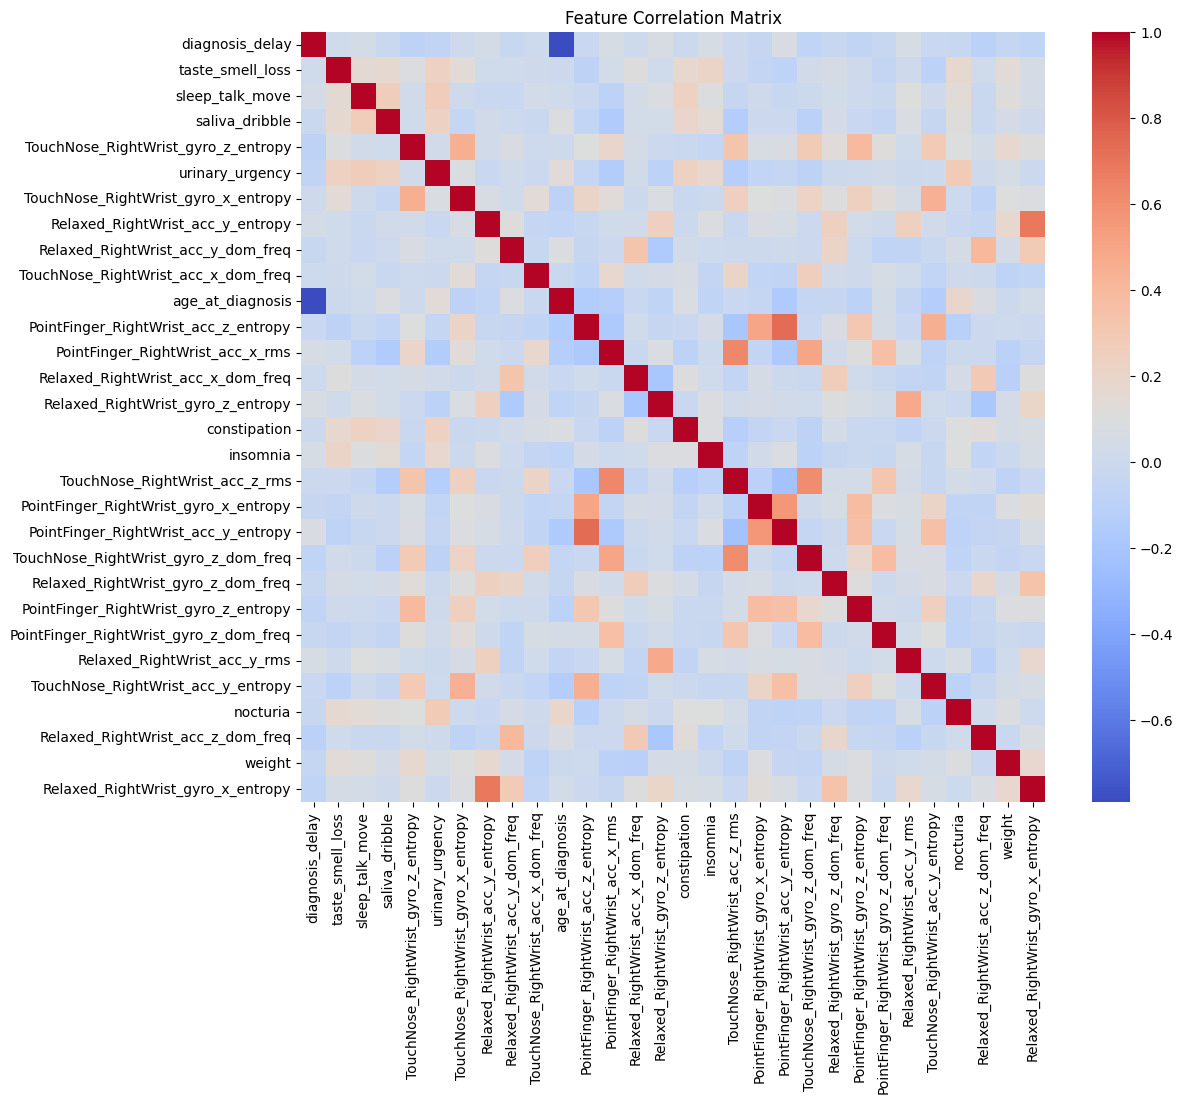

In [57]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(X_train_rf_reduced.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


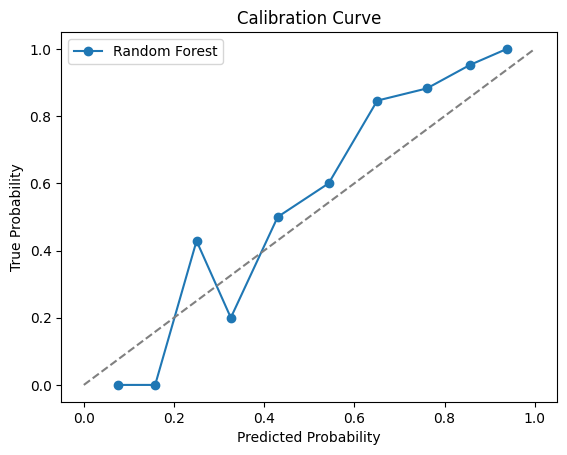

Brier Score: 0.1137994680851064


In [58]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_test, rf_tuned_preds, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.show()

brier = brier_score_loss(y_test, rf_tuned_preds)
print("Brier Score:", brier)


In [59]:
# Custom function
def fisher_score(X, y):
    scores = {}
    for col in X.columns:
        mean0, mean1 = X[y==0][col].mean(), X[y==1][col].mean()
        var0, var1 = X[y==0][col].var(), X[y==1][col].var()
        scores[col] = ((mean0 - mean1) ** 2) / (var0 + var1 + 1e-6)
    return pd.Series(scores).sort_values(ascending=False)

fdr_scores = fisher_score(X_train_rf_reduced, y_train)
print("Top Features by Fisher's Discriminant Ratio:\n", fdr_scores.head(10))


Top Features by Fisher's Discriminant Ratio:
 taste_smell_loss                       0.361033
urinary_urgency                        0.317151
sleep_talk_move                        0.313242
saliva_dribble                         0.304472
constipation                           0.215438
nocturia                               0.145915
TouchNose_RightWrist_gyro_z_entropy    0.086186
TouchNose_RightWrist_gyro_x_entropy    0.072296
weight                                 0.038753
age_at_diagnosis                       0.037674
dtype: float64


## Hyperparameter Tuning

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit on reduced feature set
grid_search.fit(X_train_rf_reduced, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate
rf_tuned_preds = best_rf.predict_proba(X_test_rf_reduced)[:, 1]
rf_tuned_auc = roc_auc_score(y_test, rf_tuned_preds)
print(f"Tuned Random Forest AUC: {rf_tuned_auc:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest AUC: 0.9150


 

# * Final Model: Random Forest (Top 30 SHAP features, tuned) <br>* AUC: 0.9150 <br>* Best features: diagnosis_delay, taste_smell_loss, TouchNose entropy <br>* Balanced performance and calibration (Brier: 0.114)

